# DRL Exercise 2: Policy Gradient Methods


Authors: Jordan Conrad-Burton and Moshe Shem Tov

## Introduction

In this assignment, we will optimize the policy of the agent directly with policy gradient methods.

First, we will implement the basic REINFORCE algorithm. Then, we will transform it into an Actor-Critic algorithm.

## Section 2: Advantage Actor-Critic

Instead of having to wait until the end of the episode before computing the advantage of each time-step, we can estimate the return $R_t$ with the Q-value $Q_w(s,a)$ using another set of weights *w*. This gives us the advantage function: $Â_t = Q_w(s_t,a_t) - V̂_v(s_t)$.

In the **actor-critic algorithm**, the TD error of the value function is used in the update of the policy function parameters instead of the advantage estimate.

**Why is using the TD error of the value function for the update of the policy network parameters practically the same as using the advantage estimate?**

The TD-error is defined as $\delta_t=R_t+\gamma V(s_t+1)-V(s_t)$, and the advantage estimate is given as $Â_t=Q_w(s_t,a_t)-V(s_t)$.

We saw in class that the action-value function Q is defined as: $Q_w(s_t,a_t)=E_π[R_t+\gamma V(S_t+1)|s_t,a_t]$.

If we substitute this into the advantage estimate: $Â_t=E_π[R_t+\gamma V(S_t+1)|s_t,a_t]-V(s_t)=R_t+\gamma V(s_t+1)-V(s_t)=\delta_t$, which shows that the advantage estimate is practically the same as using the TD error.

**Which function is the actor and which is the critic of the model?**

The actor is the policy network and the critic is the value network. The actor is responsible for choosing the actions based on the current state by taking the state and critic’s values as input. It is then updated with the gradient of the policy. The critic is responsible for estimating the value function which approximates the expected return from the current state. It takes the current state as input and sends the values to the actor who then chooses the action. It is then updated based on the difference between the expected values and the actual return.

We will now change the code that we had written for the REINFORCE and REINFORCE with baseline algorithms to implement the actor-critic algorithm. The environment remains the same: CartPole.

In [ ]:
!pip install gymnasium
!pip install torch torchvision

In [ ]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [ ]:
# average reward over 100 episodes tracking
def check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards):
    target_average = 475.0

    rewards_last_100 = rewards_per_episode[-100:]
    rolling_avg = np.mean(rewards_last_100)
    rolling_avg_rewards.append(rolling_avg)

    if rolling_avg >= target_average:
        episodes_to_target = episode + 1
        print(f"Agent reached optimal performance with an average reward of {target_average} over 100 episodes at episode {episodes_to_target}")

    return rolling_avg

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=128):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_size=128):
        super(ValueNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [ ]:
def actor_critic(env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes=1000, gamma=0.99,
                            convergence_window=100, convergence_threshold=195, optimal_performance_threshold=475):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []
    rolling_avg_rewards = []
    policy_losses = []
    value_losses = []
    convergence = False

    for episode in range(num_episodes):
        state = env.reset()

        total_reward = 0
        policy_episode_loss = 0.0
        value_episode_loss = 0.0

        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy_network(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)

            value = value_network(state_tensor)

            next_state, reward, done, _ = env.step(action.item())
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = -log_prob * td_error.detach()  # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            policy_episode_loss += policy_loss.item()
            value_episode_loss += value_loss.item()

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)
        rolling_avg_reward = check_rewards_average(rewards_per_episode, episode, rolling_avg_rewards)
        policy_losses.append(policy_episode_loss)
        value_losses.append(value_episode_loss)
        print(f"Episode {episode + 1}, Episode Reward: {total_reward}, Rolling Avg Reward: {rolling_avg_reward}")

        # check for stable convergence
        if len(rolling_avg_rewards) >= convergence_window and not convergence:
            if np.all(np.array(rolling_avg_rewards[-convergence_window:]) >= convergence_threshold):
                convergence_episode = episode
                print(f"Convergence reached at episode {episode + 1}")
                convergence = True

        if rolling_avg_reward >= optimal_performance_threshold and convergence:
            break

    return rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards

In [ ]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

value_net = ValueNetwork(state_dim)
value_optimizer = optim.Adam(value_net.parameters(), lr=0.0006)

policy_net = PolicyNetwork(state_dim, action_dim)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=0.0002171250228971598)

print("\nRunning One-Step Actor-Critic...")
rewards_per_episode, policy_losses, value_losses, rolling_avg_rewards = actor_critic(env, policy_net, value_net, policy_optimizer, value_optimizer,
                                                                                     num_episodes=2000, gamma=0.9915614564438548)

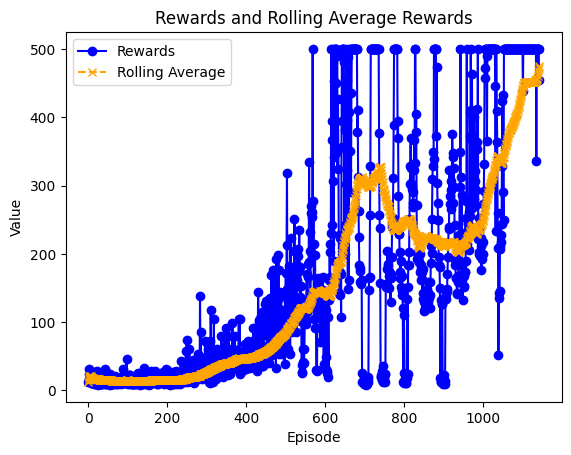

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(rewards_per_episode, label="Rewards", color="blue", linestyle='-', marker='o')
plt.plot(rolling_avg_rewards, label="Rolling Average", color="orange", linestyle='--', marker='x')
plt.title("Rewards and Rolling Average Rewards")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()

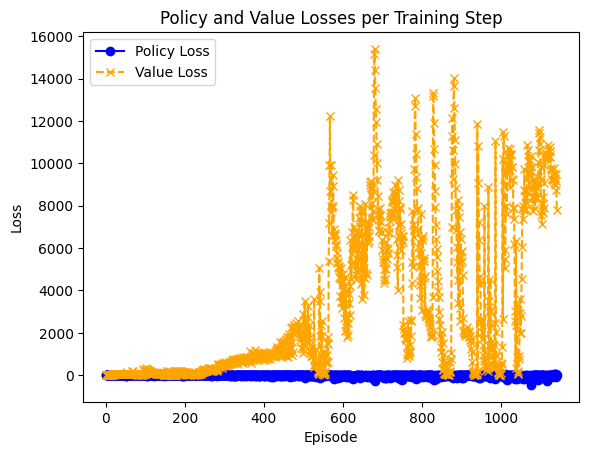

In [ ]:
# Plot: rewards and avg rewards in each training step

plt.plot(policy_losses, label="Policy Loss", color="blue", linestyle='-', marker='o')
plt.plot(value_losses, label="Value Loss", color="orange", linestyle='--', marker='x')
plt.title("Policy and Value Losses per Training Step")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Hyperparameter Tuning

Similarly to the previous exercise, we performed hyperparameter tuning. This time, however, we chose to use a random search method to find the optimal combination in order to save on runtime.

With the previous algorithms (REINFORCE and REINFORCE with baseline), we did not see the need to run hyperparameter optimization since we were getting optimal performance and convergence long before 1000 episodes. However, with the actor-critic algorithm, we saw that there were large fluctuations in the rolling averages and rewards for each episode to the point where after 1000 episodes, the rolling average was even down to single digits. So, we decided to do hyperparameter tuning on gamma and the two learning rates of the policy and value networks, looking for those parameters in which we reached optimal performance (rolling average of at least 475) within 1000 episodes because we wanted the algorithm to be able to “compete” at the same level as the others.

After running random search hyperparameter optimization multiple times, we found that the following hyperparameters gave us the best results:

* Gamma = 0.9915614564438548
* Learning rate policy = 0.0002171250228971598
* Learning rate value = 0.0006

This caused the algorithm to reach convergence at episode 742 and optimal performance at episode 1142.


In [ ]:
def random_hyperparameters():
    return {
        'gamma': random.uniform(0.99, 0.995),
        'learning_rate_policy': random.uniform(1e-4, 1e-3),
        'learning_rate_value': random.uniform(1e-4, 1e-3),
    }

In [ ]:
def actor_critic_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer, num_episodes, gamma):
    policy_network.train()
    value_network.train()

    rewards_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()

        total_reward = 0

        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            action_probs = policy_network(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)

            value = value_network(state_tensor)

            next_state, reward, done, _ = env.step(action.item())
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            # compute TD error
            with torch.no_grad():
                if not done:
                    next_value = value_network(next_state_tensor)
                else:
                    next_value = torch.tensor(0.0)

            td_error = reward + gamma * next_value - value  # δ_t = r + γV(s') - V(s)

            # update actor
            policy_loss = -log_prob * td_error.detach()  # advantage = δ_t
            policy_optimizer.zero_grad()
            policy_loss.backward()
            policy_optimizer.step()

            # update critic
            value_loss = td_error.pow(2)
            value_optimizer.zero_grad()
            value_loss.backward()
            value_optimizer.step()

            state = next_state
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return np.mean(rewards_per_episode[-100:])

In [ ]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

best_hyperparams = None
best_performance = -float('inf')
num_trials = 20

for trial in range(num_trials):
    params = random_hyperparameters()

    value_network = ValueNetwork(state_dim)
    policy_network = PolicyNetwork(state_dim, action_dim)

    policy_optimizer = optim.Adam(policy_network.parameters(), lr=params['learning_rate_policy'])
    value_optimizer = optim.Adam(value_network.parameters(), lr=params['learning_rate_value'])

    avg_reward = actor_critic_tuning(env, policy_network, value_network, policy_optimizer, value_optimizer,
                                      num_episodes=1000, gamma=params['gamma'])

    print(f"Trial {trial + 1}: {params}, Avg Reward: {avg_reward}")

    if avg_reward > best_performance:
        best_performance = avg_reward
        best_hyperparams = params

print("\nBest Hyperparameters:")
print(best_hyperparams)
print(f"Best Performance: {best_performance}")

### Discussion

In general, we can see that the actor-critic algorithm performs well, achieving convergence within 1000 episodes and optimal performance within 1200 episodes. The graph of the rewards looks similar to those of the previous algorithms except that in the actor-critic algorithm, we can see that there are large fluctuations in both the episodic rewards and the rolling average, more so than we saw in the algorithms from section 1. These algorithms had consistent upwards trends with some fluctuations but the actor-critic algorithm had such serious fluctuations that it is not possible to say that there was a similar consistent upwards trend in the rolling average rewards. In addition, the actor-critic algorithm reached convergence at episode 742 and optimal performance at episode 1142, after both of the other algorithms with convergence at episodes 487 (REINFORCE) and 392 (REINFORCE with baseline) and optimal performances at episodes 857 (REINFORCE) and 686 (REINFORCE with baseline).

By looking at the graph of the losses, we can see that the loss of the value network (critic) reaches very large amounts and fluctuates between very high loss and very low. The network does not start out with such large variance in the loss, but it persists throughout the entire run, even though eventually convergence and optimal performance were reached. This could be caused by the fact that the value network is updated too frequently or is sensitive to noise, creating large fluctuations. This is probably one of the main reasons that this algorithm is slower to converge and reach optimal performance as opposed to the previous two. We did perform hyperparameter tuning via random search and attempted to find the best hyperparameters for the network, however hyperparameter optimization by random search does not guarantee finding the most optimal hyperparameters, and so we are certain that there are other values that could suit this algorithm better.

We can see that there is a significant difference in the performances of these three algorithms with actor-critic performing the worst and REINFORCE with baseline performing the best in terms of number of episodes the algorithm takes to converge and to reach optimal performance. However, it must be noted that all three algorithms converged under 1000 episodes and reached optimal performance under 1200 episodes, performing better than the algorithms did in our previous exercise.
